# MREN223 Lab2 - Quadrotor System

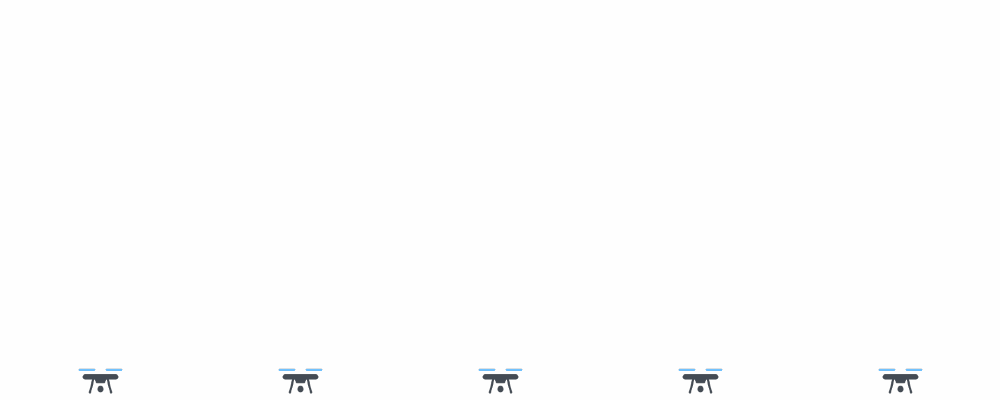

In this lab, we will look at systems. We will design a set of quadrotors that dance up and down to music. Similar to a music visualizer but with quadrotors.

In this lab, we will be using the following libraries:
`pip install scipy numpy matplotlib`

Additionally, we will use scipy's wavfile function to import wave music files, and soundevice to play the music file in Jupyter notebook.

`pip install sounddevice`

In [1]:
import scipy
from  scipy import signal
from scipy.fft import fft, ifft, fftfreq, fftshift
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import PillowWriter  
import numpy as np
import pandas as pd
import sounddevice as sd
from scipy.io import wavfile
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from IPython.display import HTML
%matplotlib inline

## Quadrotor Design

<img src="quadIcon.png"/>
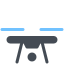

![Drone Icon](quadIcon.png)

We will apply a simplistic model for the up-down motion of a quadrotor. 

We will asume that the force applied by each of the 4 wings is equal and the total upward force is $F_r$. 
We will also assume that some air drag is applied on the quadrotor as it moves which is equal to $b\dot{y}$; $\dot{y}$  is the velocity.
The dynamics of the quadrotor can then be modelled by
$$F_r - mg - b\dot{y} = m\ddot{y}$$

where $\ddot{y}$ is the upward acceleration of the quadrotor and $mg$ is the quadrotor weight.

*Exercise #1:* Find the transfer function of the quadrotor $G(s)$.

We will also apply a controller in a unity feedback loop to the quadrotor. 
We have designed a (PD: as you will learn in later control courses) so that we can give the quadrotor a desired elevation and for it to follow it.

The controller in s-domain is: $G_c(s) = K_D s + K_P$

The transfer function of the feedback system is $$H(s) = \frac{G_c(s) G(s)}{ 1 + G_c(s) G(s)} = \frac{K_D s + K_P}{m s^2 + (b+K_D)s + K_P}$$

We have a quadrotor with a mass $m = 1 kg$ and the drag coefficient is $b = 0.05$.

We will now plot the reaction (elevation) of the quadrotor if it is on the ground and we command it to rise to an elevation of 1 meter above ground.

In [3]:
# Designing the controller and defining the feedback system as an linear time-invariant (LTI) on scipy
# look up the function scipy.signal.lti to understand what it does
kd = 20
kp = kd * 10

H = signal.lti([kd, kp], [1, 0.05+kd, kp])

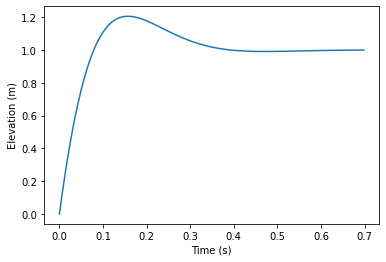

In [4]:
plt.plot(H.step()[0], H.step()[1])
plt.xlabel('Time (s)')
plt.ylabel('Elevation (m)');

You can change the values of $K_P$ and $K_D$ to modify the rise of the quadrotor. 

*Exercise #2*: Experiment with different values of $K_P$ and $K_D$. What conclusions can you arrive to about the effect of changing them?

We can animate the quadrotor motion with the code below.

In [5]:
%matplotlib notebook

In [6]:
quadElevation = H.step()[1]
path = 'quadIcon.png'
x = 0.5

fig = plt.figure(figsize=(3, 7))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(0, 1), ax.set_xticks([])
ax.set_ylim(0, 1.4), ax.set_yticks([])

def animate(i):
    ax.cla()
    ax.set_xlim(0, 1), ax.set_xticks([])
    ax.set_ylim(0, 1.4), ax.set_yticks([])
    ab = AnnotationBbox(OffsetImage(plt.imread(path, format="png"), zoom=0.5), (x, quadElevation[i]), frameon=False)
    ax.add_artist(ab)

ani = matplotlib.animation.FuncAnimation(fig, animate, interval=20, frames=len(quadElevation));

<IPython.core.display.Javascript object>

Let's simulate the response (elevation) of the drone when we command it to follow a biased sinusoidal signal $y_d = 1.1 + sin(4 t)$.

*Exercise #3*: Read and use the `signal.lsim` function to plot and animate the response of the drone to $y_d$ (as done for the step input above).

In [7]:
%matplotlib inline

In [8]:
t = np.arange(0,5,0.01)
yd = np.sin(4*t)+1.1
#y = signal.lsim() -- Modify this line

NameError: name 'y' is not defined

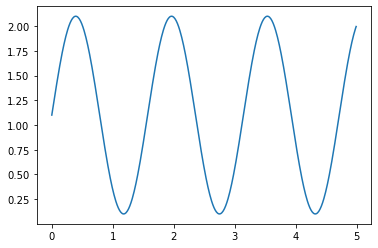

In [9]:
plt.plot(t, yd)
plt.plot(t, y[1])
plt.xlabel('Time (s)')
plt.ylabel('Elevation (m)')
plt.legend(['Control input', 'Drone']);

In [11]:
%matplotlib notebook
y = np.array([0,1,2,3,4,5,6,7,8,9])

In [12]:
quadElevation = y[1]
path = 'quadIcon.png'
x = 0.5

fig = plt.figure(figsize=(3, 7))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(0, 1), ax.set_xticks([])
ax.set_ylim(0, 2.7), ax.set_yticks([])

def animate(i):
    ax.cla()
    ax.set_xlim(0, 1), ax.set_xticks([])
    ax.set_ylim(0, 2.7), ax.set_yticks([])
    ab = AnnotationBbox(OffsetImage(plt.imread(path, format="png"), zoom=0.5), (x, quadElevation[i]), frameon=False)
    ax.add_artist(ab)

ani = matplotlib.animation.FuncAnimation(fig, animate, interval=10, frames=len(quadElevation));

<IPython.core.display.Javascript object>

TypeError: object of type 'numpy.int32' has no len()

## Sound Processing 

Next, let's look at processing sounds in Python.

In [ ]:
%matplotlib inline

In [ ]:
# Helper functions
def load_music(filename):
    '''
    Takes the location of the music WAV file as a input and returns 
    the sampling frequency (Hz) of the sound file, the time array 
    of the digital sound signal (sec), and the sound channels.
    
    inputs:
        filename (str)
    outputs:
        fs (int)
        t List[float]
        channels List[List[float]]
    '''
    fs, data = wavfile.read(filename)
    num_channels = np.shape(data)[1]
    
    L = np.shape(data)[0]
    t = np.array(range(0, L))/fs

    channels = {}
    for n in range(num_channels):
        channels[str(n+1)] = [data[i][n] for i in range(L)]
    
    return fs, t, channels

def write_music(filename, data, fs):
    '''
    Writes the sound data into a WAV file with location filename. 
    The sampling frequency is given in Hz, and the data is given as
    a dictionary of which the values are the channels in the music file.
    
    inputs:
        filename (str)
        data Dict{any: List[float]}
        fs (int)
    outputs:
        None
    '''
    df = pd.DataFrame(data)
    wavfile.write(filename=filename, rate=fs, data=np.array(df).astype(np.int16))
    return None

def freq_spectrum(data, fs, lim=None):
    '''
    Plots the frequency spectrum of music channels with sampling frequency fs (Hz).
    
    inputs:
        data List[float]
        fs (int)
        lim (optional to limit plots x-axis) (float)
    outputs:
        None
    '''
    N = np.size(data)

    yf = fft(data) # fft of the signal 

    xf = fftfreq(N, 1/fs)
    xf = fftshift(xf) #  preparing the x-axis for the spectrum

    yplot = fftshift(yf)

    plt.plot(xf, 1.0/N * np.abs(yplot))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    if lim is not None:
        plt.xlim([-lim,lim])
    plt.grid()
    return None

We will import an excerpt of Mozart's Alla Turca and practice some sound processing on it. We will use the helper function 'load_music' to import it.

In [ ]:
fs, t, channels = load_music('Mozart_Alla_Turca_excerpt.wav')

The file has two sound channels (think music to left and right ears). We can seperate them and plot them as continuous time signals.

In [ ]:
channel1, channel2 = (channels['1'], channels['2'])

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(t, channel1)
ax1.set_title('Channel 1')

ax2.plot(t, channel2,  'r')
ax2.set_title('Channel 2')
ax2.set_xlabel('Time (s)');

The above plots shows that the sound file is 46 seconds long. Let's plot its frequency spectrum to observe the frequencies it contains. You can change the value of lim to limit the Frequency (Hz) axis.

In [ ]:
freq_spectrum(data=channel1, fs=fs, lim=None)

Let's apply a low pass filter to remove high frequency noise and see if we can make the sound crisper. 
We have seen how to design a butterworth filter in Lab 1. 

We will design a 4th order butterworth low pass filter to remove frequency components higher than 2000 Hz. 

In [ ]:
b, a = signal.butter(4, 1000, 'lowpass', analog=True)  #4 is filter order, the higher the more precise the filter, 
                                                                #[0,2000] band of frequencies in rad/s to pass
w, h = signal.freqs(b, a) # computes the filter's frequency response

plt.semilogx(w, 20*np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Magnitude (dB)')
plt.grid(which='both', axis='both')

Let's apply the filter to channel 1 of the sound file and observe its effect.

We will first look at the effect on the time signal. Next, we will observe the effect on the frequency spectrum, and lastly we will hear the audio and try to notice its effect.

In [ ]:
sig = channel1[5*4410:6*4410] # signal from before
sos = signal.butter(4, 1000, 'lowpass', fs=fs, output='sos')
filtered = signal.sosfilt(sos, sig) # filtered signal

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(t[5*4410:6*4410], sig)
ax1.set_title('Before filtering')
ax1.set_ylabel('y[n]')

ax2.plot(t[5*4410:6*4410], filtered)
ax2.set_title('After filtering')
ax1.set_ylabel('y[n]')

ax2.set_xlabel('Time (s)')
plt.tight_layout()

In [ ]:
channel1_filtered = signal.sosfilt(sos, channel1) # filtered channel 1
channel2_filtered = signal.sosfilt(sos, channel2) # filtered channel 2

freq_spectrum(data=channel1, fs=fs, lim=None)
freq_spectrum(data=channel1_filtered, fs=fs, lim=None)

Below, we will write the music to a WAV file. Listen to the original and filtered sound files using your computer audio player.

In [ ]:
write_music(filename='mozart_filtered.wav', data={'1': channel1_filtered, '2':channel2_filtered}, fs=fs)

## Lab Description

*Exercise #4*: We will use the matplotlib animation functionality (demonstrated above with the single drone) and sound processing to design a drones' dance to music.
In this lab, you will be mainly tested on the evidence and explanation of the methods you used to process the music to a form that the drones can dance to. Do not sweat not having a perfect coherent dance in the end as it is not the goal of the lab.

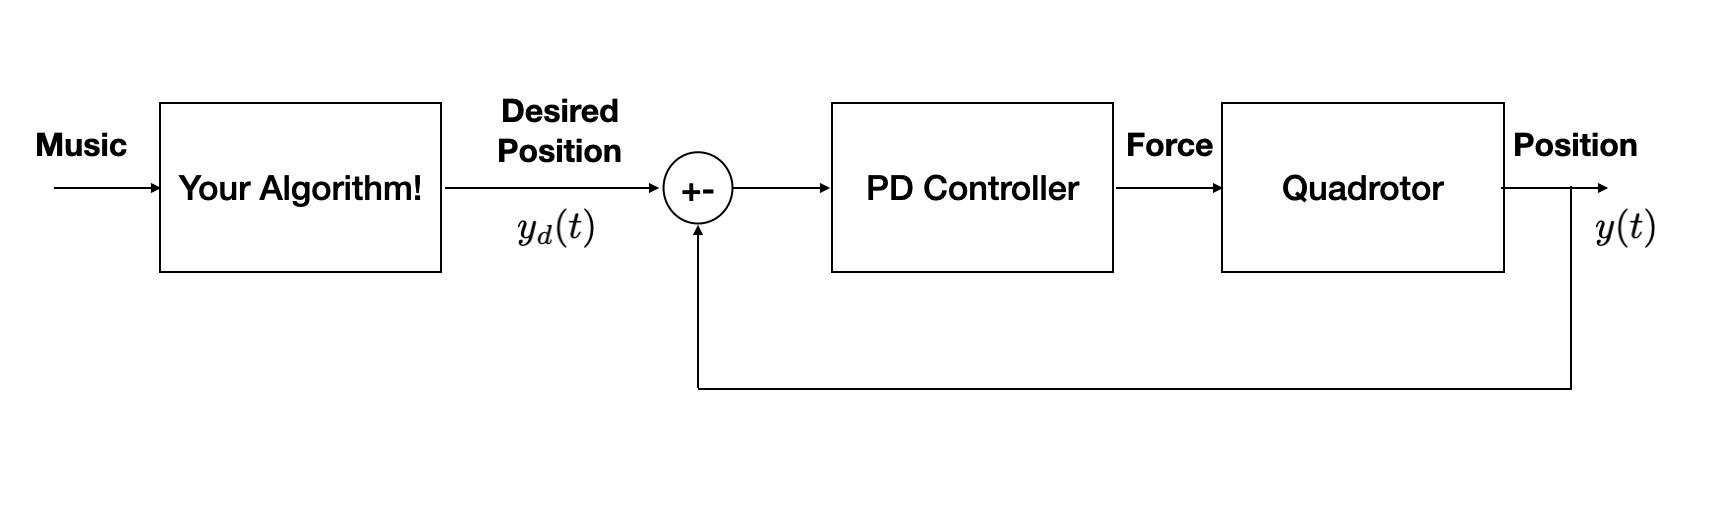

1) Search for the music to which the drones will dance. 
Note that some music will be easier to design the dance for. For example, slower music might be easier to work with than a fast beat. 
If you use scipy to upload the sound file into the Python IDE, you will need to convert the sound file to WAV format. You can use any free online software for that. You can alternatively try to find another library (other than scipy) that let's you upload another format. 

2) Trim the sound file to a 20 to 60 seconds segment, which you will work with. Again, try to make it so that the rest of the work is easy for you.

3) (Optional) You can filter your music to further clean (or process) it for cleaner data. 

4) Brainstorm ideas to process the music into a dance routine for the drones. This is completely up to you. Here are a few ideas to get you started, but feel free to work in any direction that inspires you.
- Segment the music into short intervals and process the frequency spectrum of each. Have a drone rise up in proportion to the magnitude of some frequency range.
- You can have as many as 10 drones dancing together or as little as one. You can retreive other drone icons from https://icons8.com/icons/set/quadrotor
- Filter a slow frequency tone, and have a drone move in rythm to it.
- Program a dance routine that changes speed according to the music interval frequency, base, or amplitude.
- You can recolor the animation's background to the music.

5) Process the music to an input time signal to (each) drone. To simulate the drones' response to the input, you can use scipy's `signal.lsim` function.

6) Animate the drone dance to the music. You will need to build on the animation code included above. Review the `matplotlib.animation.FuncAnimation` function parameters. 
Note that you need have to specify the frames and interval parameters of the function. Do not leave them to default values.

To play music while the drones are dancing, just run sounddevice's `play` function before the animation.

`sd.play(data, fs)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames, interval, repeat=False);`

Notes: 
- If you need to smoothen the input to the drones, you can use `scipy.interpolate.interp1d` function.

There is an additional 1% (of the course grade) available for very creative ideas!

The lab will be graded out of 10 points:
Exercise #1: 1 point
Exercise #2: 2 points
Exercise #3: 3 points
Exercise #4: 4 points (loading music: 1, trimming music: 1, play and animate quadrotor: 1, your idea: 1)